In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
from sklearn.model_selection import train_test_split
data = np.genfromtxt('../dataset/training_data_LSTM_FS_3_wrist.csv', delimiter=',')
train, test = train_test_split(data, test_size=0.2)
print(train.shape)
print(test.shape)

(1608, 44)
(402, 44)


In [3]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized Confusion Matrix'
        else:
            title = 'Confusion Matrix, without Normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, without Normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(20, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center", fontsize=15,
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [4]:
n_original_input = 43     # 입력데이터의 속성 수
n_input = 43
n_step = 5       # 한 번에 입력할 데이터 수
n_class = 11     # 결과값의 종류 수 (Activity 1~11)
batch_size = 1   # 배치 크기 (ex. n_step개 데이터 batch_size묶음이 1배치)
n_epoch = 50     # 총 학습 횟수

n_hidden = 128
learning_rate = 0.001

In [5]:
# epoch 당 batch 수 계산
train_batch = train.shape[0]//(batch_size*n_step)
print(train_batch)
test_batch = test.shape[0]//(batch_size*n_step)
print(test_batch)

321
80


In [6]:
x_train = train[:, :n_original_input]
y_train_temp = train[:, -1]

#x_train = x_train[:, [0, 1, 2, 3, 4, 5, 6, 7, 16, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 59, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 102, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 132, 133, 135, 136, 137]]

sess = tf.Session()
y_train_temp = np.subtract(y_train_temp, np.ones(y_train_temp.shape))
y_train_temp = tf.one_hot(y_train_temp, depth=n_class).eval(session=sess)

y_train = np.zeros([train_batch, n_class])
for i in range(train_batch):
    y_train[i] = y_train_temp[n_step * i]

x_train = x_train.tolist()
y_train = y_train.tolist()

print(len(x_train))
print(len(y_train))

1608
321


In [7]:
x_test = test[:, :n_original_input]
y_test_temp = test[:, -1]

#x_test = x_test[:, [0, 1, 2, 3, 4, 5, 6, 7, 16, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 59, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 102, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 132, 133, 135, 136, 137]]

#sess = tf.Session()
y_test_temp = np.subtract(y_test_temp, np.ones(y_test_temp.shape))
y_test_temp = tf.one_hot(y_test_temp, depth=n_class).eval(session=sess)

y_test = np.zeros([test_batch, n_class])
for i in range(test_batch):
    y_test[i] = y_test_temp[n_step * i]

x_test = x_test.tolist()
y_test = y_test.tolist()

print(len(x_test))
print(len(y_test))

402
80


In [8]:
# 현재 iteration의 batch를 반환하는 함수
def get_batch(x, y, iteration, size = batch_size):
  start = size*iteration
  batch_x = []
  batch_y = []
  for i in range(size):
    batch_x.append(x[(start+i)*n_step:(start+i+1)*n_step])
    batch_y.append(y[start+i])
  return batch_x, batch_y

In [9]:
# RNN 구성
X = tf.placeholder(tf.float32, [None, n_step, n_input], name='x')
Y = tf.placeholder(tf.int32, [None, n_class], name='y')

W = tf.Variable(tf.truncated_normal([n_hidden, n_class]))
b = tf.Variable(tf.truncated_normal([n_class]))

cell1 = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)
cell1 = tf.nn.rnn_cell.DropoutWrapper(cell1, output_keep_prob=1)
cell2 = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)
cell2 = tf.nn.rnn_cell.DropoutWrapper(cell2, output_keep_prob=0.8)
cell3 = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)
cell3 = tf.nn.rnn_cell.DropoutWrapper(cell3, output_keep_prob=1)
cell4 = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)
cell4 = tf.nn.rnn_cell.DropoutWrapper(cell4, output_keep_prob=0.8)
cell5 = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)
cell5 = tf.nn.rnn_cell.DropoutWrapper(cell5, output_keep_prob=1)
cell6 = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)
cell6 = tf.nn.rnn_cell.DropoutWrapper(cell6, output_keep_prob=0.8)
cell7 = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)
cell7 = tf.nn.rnn_cell.DropoutWrapper(cell7, output_keep_prob=1)
cell8 = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)

multi_cell = tf.nn.rnn_cell.MultiRNNCell([cell1, cell2, cell3, cell4, cell5, cell6, cell7, cell8])

output, state = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
output = tf.transpose(output, [1,0,2])
output = output[-1]

model = tf.matmul(output, W) + b

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [11]:
is_correct = tf.equal(tf.argmax(model, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

epoch: 1, avg.loss: 2.401130
epoch: 2, avg.loss: 2.106394
epoch: 3, avg.loss: 2.008120
epoch: 4, avg.loss: 1.963456
epoch: 5, avg.loss: 1.941262
epoch: 6, avg.loss: 1.889888
epoch: 7, avg.loss: 1.880580
epoch: 8, avg.loss: 1.871906
epoch: 9, avg.loss: 1.847015
epoch: 10, avg.loss: 1.845069
epoch: 11, avg.loss: 1.802755
epoch: 12, avg.loss: 1.794028
epoch: 13, avg.loss: 1.781432
epoch: 14, avg.loss: 1.822534
epoch: 15, avg.loss: 1.730718
epoch: 16, avg.loss: 1.693014
epoch: 17, avg.loss: 1.690673
epoch: 18, avg.loss: 1.640861
epoch: 19, avg.loss: 1.602285
epoch: 20, avg.loss: 1.641877
epoch: 21, avg.loss: 1.613479
epoch: 22, avg.loss: 1.633810
epoch: 23, avg.loss: 1.463119
epoch: 24, avg.loss: 1.462824
epoch: 25, avg.loss: 1.432099
epoch: 26, avg.loss: 1.397585
epoch: 27, avg.loss: 1.379528
epoch: 28, avg.loss: 1.390799
epoch: 29, avg.loss: 1.331912
epoch: 30, avg.loss: 1.289446
epoch: 31, avg.loss: 1.239930
epoch: 32, avg.loss: 1.182369
epoch: 33, avg.loss: 1.295559
epoch: 34, avg.loss

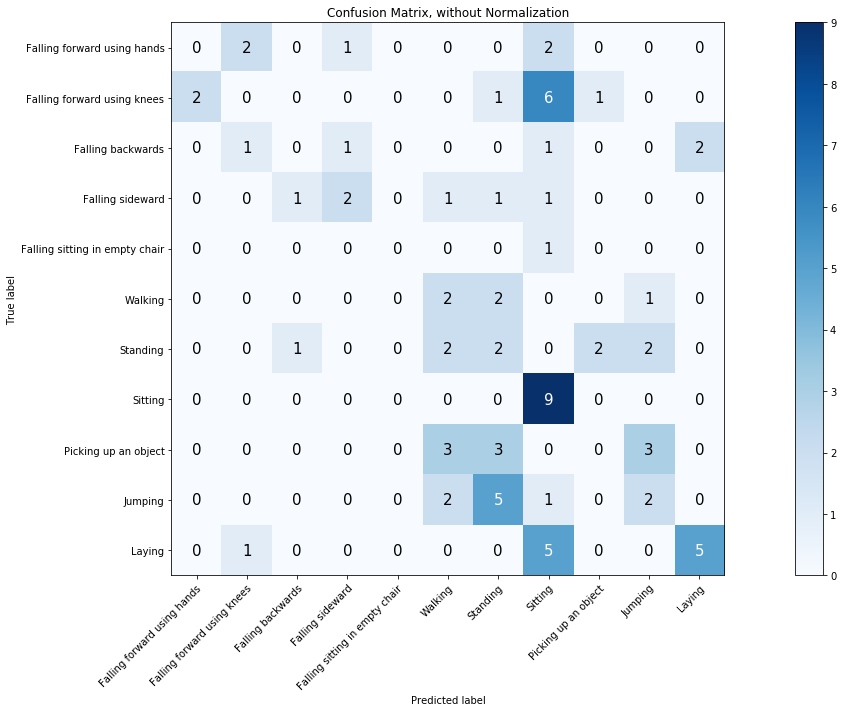

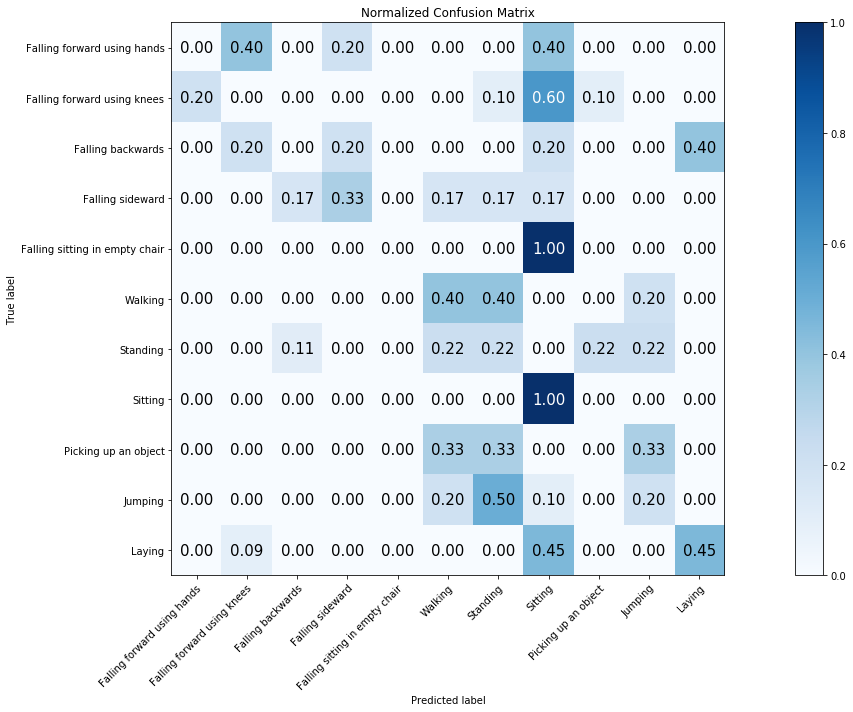

In [12]:
# 세션 실행
with tf.Session() as sess:
  tf.global_variables_initializer().run()

  # 학습
  for i in range(n_epoch):
    total_loss = 0
    for j in range(train_batch):
      batch_x, batch_y = get_batch(x_train, y_train, j)
      _, loss = sess.run([optimizer, cost], feed_dict={X: batch_x, Y: batch_y})
      total_loss += loss
    print('epoch: %d, avg.loss: %f'%(i+1, total_loss/train_batch)) 

  # 모델 테스트
  total_acc = 0
  for k in range(train_batch):
    test_x, test_y = get_batch(x_train, y_train, k)
    acc = sess.run(accuracy, feed_dict={X: test_x, Y: test_y})
    total_acc += acc
  print('---train accuracy: %f,'%(total_acc/train_batch))

  # 테스트
  total_acc = 0
  for k in range(test_batch):
    test_x, test_y = get_batch(x_test, y_test, k)
    acc = sess.run(accuracy, feed_dict={X: test_x, Y: test_y})
    total_acc += acc
  print('---test accuracy: %f,'%(total_acc/test_batch))
    
  # confusion matrix
  '''
  train_x, train_y = get_batch(x_train, y_train, 0, train_batch)
  cm = tf.confusion_matrix(tf.argmax(train_y, 1), tf.argmax(sess.run(model, feed_dict={X: train_x, Y: train_y}), 1), n_class)
  test_x, test_y = get_batch(x_test, y_test, 0, test_batch)
  cm += tf.confusion_matrix(tf.argmax(test_y, 1), tf.argmax(sess.run(model, feed_dict={X: test_x, Y: test_y}), 1), n_class)
  # df_cm = pd.DataFrame(sess.run(cm), range(n_class), range(n_class))
  df_cm = pd.DataFrame(sess.run(cm), index=["Falling forward using hands", "Falling forward using knees", "Falling backwards", "Falling sideward", "Falling sitting in empty chair", "Walking", "Standing", "Sitting", "Picking up an object", "Jumping", "Laying"], columns=["Falling forward using hands", "Falling forward using knees", "Falling backwards", "Falling sideward", "Falling sitting in empty chair", "Walking", "Standing", "Sitting", "Picking up an object", "Jumping", "Laying"])
  # plt.figure(figsize = (10,7))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
  '''
  np.set_printoptions(precision=2)
  test_x, test_y = get_batch(x_test, y_test, 0, test_batch)
  y_pred = sess.run(model, feed_dict={X: test_x, Y: test_y})
  y_pred = np.argmax(y_pred, axis=1).reshape(-1)
  print(y_pred.shape)
  print(y_pred)
  classes = ['Falling forward using hands', 'Falling forward using knees', 'Falling backwards', 'Falling sideward', 'Falling sitting in empty chair', 'Walking', 'Standing', 'Sitting', 'Picking up an object', 'Jumping', 'Laying']

  y_act = np.argmax(y_test, axis=1).reshape(-1)
  print(y_act.shape)
  print(y_act)

  # Plot non-normalized confusion matrix
  plot_confusion_matrix(y_act, y_pred, classes=classes, title='Confusion Matrix, without Normalization')

  # Plot normalized confusion matrix
  plot_confusion_matrix(y_act, y_pred, classes=classes, normalize=True, title='Normalized Confusion Matrix')

  plt.show()

  sess.close()